In [1]:
# Hidden Config Cell

# from maccabee.constants import Constants
# Constants.DGPSampling.NORMALIZE_SAMPLED_OUTCOME_FUNCTION = True
# Constants.DGPSampling.CENTER_SAMPLED_OUTCOME_FUNCTION = True
# Constants.DGPSampling.NORMALIZE_SAMPLED_TREATMENT_FUNCTION = True
# Constants.DGPSampling.ADJUST_ALIGNMENT = True

from maccabee.parameters import ParameterStore
import numpy as np

def coeff_sampler(self, size=1):
    vals = np.random.uniform(low=1, high=10, size=size)
    neg_locs = (np.random.random(size=size) < 0.5)
    neg_mask = np.full(size, 1)
    neg_mask[neg_locs] = -1
    return vals*neg_mask

def te_sampler(self, size=1):
    return np.random.normal(loc=0, scale=3, size=size)
    
def noise_sampler(self, size=1):
    return np.random.normal(scale=0.25, size=size)
    
ParameterStore.sample_subfunction_constants = coeff_sampler
ParameterStore.sample_treatment_effect = te_sampler
ParameterStore.sample_outcome_noise = noise_sampler

#!python -m pip install -e ../../../../Maccabee > /dev/null

In [2]:
from maccabee.data_analysis.data_metrics import AXES_AND_METRICS
from maccabee.constants import Constants
    
for i, metric in enumerate(AXES_AND_METRICS[Constants.AxisNames.OUTCOME_NONLINEARITY], 1):
    print(i, metric["name"])

1 Lin r2(X_obs, Y)
2 Lin r2(X_true, Y)
3 Lin r2(X_obs, Y1)
4 Lin r2(X_obs, Y0)
5 Lin r2(X_true, Y1)
6 Lin r2(X_true, Y0)
7 Lin r2(X_obs, TE)
8 Lin r2(X_true, TE)


In [3]:
# Define axes and metrics to analyze
DATA_METRICS_SPEC = {
    Constants.AxisNames.OUTCOME_NONLINEARITY: [
        "Lin r2(X_obs, Y)",
        "Lin r2(X_obs, Y0)",
    ]
}

In [4]:
from maccabee.parameters import build_parameters_from_axis_levels

# Build the parameters
low_nonlin_params = build_parameters_from_axis_levels({
  Constants.AxisNames.OUTCOME_NONLINEARITY: Constants.AxisLevels.LOW,
})

high_nonlin_params = build_parameters_from_axis_levels({
  Constants.AxisNames.OUTCOME_NONLINEARITY: Constants.AxisLevels.HIGH,
})

In [30]:
from maccabee.data_sources.data_source_builders import build_random_normal_datasource
from maccabee.benchmarking import benchmark_model_using_sampled_dgp
from maccabee.modeling.models import LinearRegressionCausalModel

# Build a random normal data source
normal_data_source = build_random_normal_datasource(
    n_covars=5,
    n_observations=1000)

# Run the benchmarks for both sets of params
results = []
for params in [low_nonlin_params, high_nonlin_params]:
    result = benchmark_model_using_sampled_dgp(
        dgp_sampling_params=params,
        model_class=LinearRegressionCausalModel,
        estimand=Constants.Model.ATE_ESTIMAND,
        data_source=normal_data_source,
        num_dgp_samples=32,
        num_sampling_runs_per_dgp=1,
        num_samples_from_dgp=40,
        data_analysis_mode=True, # SET DATA ANALYSIS MODE
        data_metrics_spec=DATA_METRICS_SPEC, # PROVIDE SPEC
        n_jobs=8)
    
    results.append(result)

In [59]:
_, _, _, low_data_metric_agg, low_data_metrics_raw, _ = results[0]
_, _, _, high_data_metric_agg, high_data_metrics_raw, _ = results[1]

In [39]:
low_data_metric_agg

{'OUTCOME_NONLINEARITY Lin r2(X_obs, Y)': 0.884,
 'OUTCOME_NONLINEARITY Lin r2(X_obs, Y0)': 1.0}

In [40]:
low_data_metrics_raw["OUTCOME_NONLINEARITY Lin r2(X_obs, Y)"][:5]

[0.929, 0.636, 0.94, 0.825, 0.974]

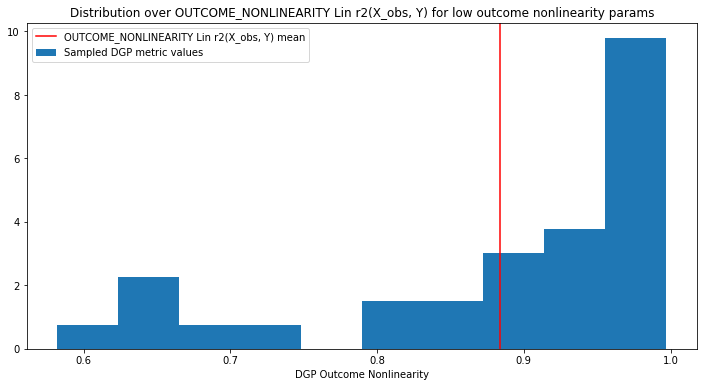

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
metric = "OUTCOME_NONLINEARITY Lin r2(X_obs, Y)"
plt.hist(low_data_metrics_raw[metric], density=True, label="Sampled DGP metric values")
plt.axvline(x=low_data_metric_agg[metric], c="r", label=f"{metric} mean")
plt.xlabel("DGP Outcome Nonlinearity")
plt.title(f"Distribution over {metric} for low outcome nonlinearity params")
plt.legend()
plt.show()

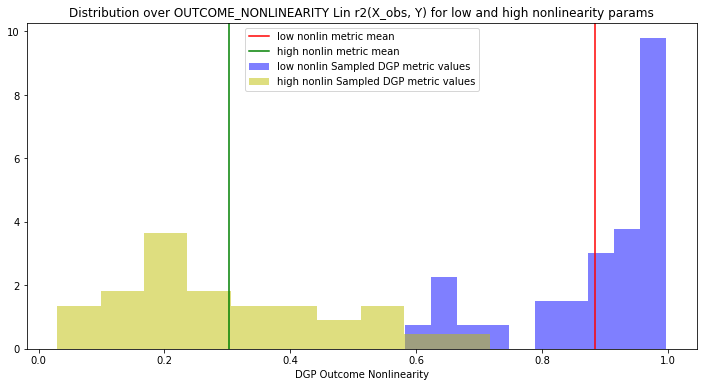

In [60]:
plt.figure(figsize=(12, 6))
metric = "OUTCOME_NONLINEARITY Lin r2(X_obs, Y)"

plt.hist(low_data_metrics_raw[metric], density=True,
         color="b", label="low nonlin Sampled DGP metric values", alpha=0.5)
plt.axvline(x=low_data_metric_agg[metric],
            c="r", label="low nonlin metric mean")

plt.hist(high_data_metrics_raw[metric], density=True,
         color="y", label="high nonlin Sampled DGP metric values", alpha=0.5)
plt.axvline(x=high_data_metric_agg[metric],
            c="g", label="high nonlin metric mean")

plt.xlabel("DGP Outcome Nonlinearity")
plt.ylabel("DGP Outcome Nonlinearity")
plt.title(f"Distribution over {metric} for low and high nonlinearity params")
plt.legend()
plt.show()